In [1]:
import sys
import os
import os.path
import fnmatch
from lxml import etree
from lxml.etree import tostring
import re
from collections import defaultdict
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pylab import plot
import pickle
import re
import matplotlib.patches as mpatches
from nltk.tokenize import word_tokenize

/home/odysseus/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def process_files(list_of_files, path_in):
    
    words_dict=defaultdict(list)
    length_dict=defaultdict(list)
    chaps_dict=defaultdict(list)
    divs_dict=defaultdict(list)
    first_dict=defaultdict(list)
    last_dict=defaultdict(list)
    first_ent_dict=defaultdict(list)
    last_ent_dict=defaultdict(list)
    plot_words=OrderedDict()
    plot_chaps=OrderedDict()
    plot_div1=OrderedDict()
    plot_div2=OrderedDict()
    plot_div3=OrderedDict()
    plot_length=OrderedDict()
    plot_first=OrderedDict()
    plot_last=OrderedDict()
    plot_ent_first=OrderedDict()
    plot_ent_last=OrderedDict()
    filtered=list()
    bugs=list()
    stats=defaultdict(list)
    
    print("Processing "+str(len(list_of_files))+" files. Please wait, this might take some time.")

    for tmpFile in list_of_files:

        tmpFile=tmpFile.replace("/",":")
        fullPath=path_in+tmpFile

        print("\nProcessing file "+tmpFile)

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)

        #yearKey=int(tmpFile[:3]+"0")
            yearKey=int(tmpFile[:4])

            words_dict=num_words(words_dict,tree, yearKey, bugs, tmpFile)
            #print(words_dict.keys())
            chaps_dict=num_chapters(chaps_dict,tree,yearKey, bugs,tmpFile)
            
            divs_dict=num_divs(divs_dict, tree, yearKey, bugs, tmpFile)
            
            length_dict=length(length_dict, tree.getroot(), yearKey)
            
            first_dict=num_first(first_dict, tree, yearKey, tmpFile)
            
            last_dict=num_last(last_dict, tree, yearKey, tmpFile)
            
            first_ent_dict=num_ent_first(first_ent_dict, tree, yearKey, tmpFile)
            
            last_ent_dict=num_ent_last(last_ent_dict, tree, yearKey, tmpFile)
            

    plot_words=words_for_plot(words_dict, plot_words)
    plot_chaps=words_for_plot(chaps_dict, plot_chaps)
    plot_length=words_for_plot(length_dict, plot_length)
    plot_div1=divs_for_plot(divs_dict, plot_div1,1)
    plot_div2=divs_for_plot(divs_dict, plot_div2,2)
    plot_div3=divs_for_plot(divs_dict, plot_div3,3)
    plot_first=words_for_plot(first_dict, plot_first)
    plot_last=words_for_plot(last_dict, plot_last)
    plot_ent_first=words_for_plot(first_ent_dict, plot_ent_first)
    plot_ent_last=words_for_plot(last_ent_dict, plot_ent_last)
    #print(bugs)
    fit_words = lin_reg(plot_words)
    fit_chaps = lin_reg(plot_chaps)
    
    print(first_dict)
    print(last_dict)
    
    stats["chapter"].append(fit_chaps)
    stats["chapter"].append(plot_chaps)
    stats["word"].append(fit_words)
    stats["word"].append(plot_words)
    stats["divs"].append(plot_div1)
    stats["divs"].append(plot_div2)
    stats["divs"].append(plot_div3)
    stats["length"].append(plot_length)
    stats["exts"].append(plot_first)
    stats["exts"].append(plot_last)
    stats["ents"].append(plot_ent_first)
    stats["ents"].append(plot_ent_last)
    
    return stats

    #del filtered
    del words_dict
    del chaps_dict
    del plot_words
    del plot_chaps

In [3]:
def lin_reg(series):

    x = np.array(list(series.keys()))
    y = np.array(list(series.values()))

    x = sm.add_constant(x)

    return sm.OLS(y, x).fit()

In [4]:
def movingaverage (values, window):
    weights = np.repeat(1.0, window)/window
    sma = np.convolve(values, weights, 'valid')
    return sma

In [5]:
def plot_stats (fit, plot,limitsX,limitsY, sliding, mycolor, title):
    x1 = list(plot.keys())[0]
    x2 = list(plot.keys())[-1]
    y1 = fit.predict()[0]
    y2 = fit.predict()[-1]
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    #print(len(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.figure(figsize=(10, 6))
    plt.plot(list(plot.keys()), list(plot.values()))
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.title(title)
    plt.plot([x1, x2], [y1, y2], color='gray', linewidth=0.5)
    #plt.xlim(min(plot.keys()),max(plot.keys()))
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    #print(plot.keys())
    plt.show()

In [6]:
def simple_plot (plot, limitsX, limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot.keys()))
    y = np.array(list(plot.values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=5,color=mycolor)
    plt.plot(x,y)
    plt.title(title)
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.show()

In [7]:
def multiple_plots (min_year, max_year, nb_words, nb_words_chap, stats):
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['word'][1].keys()))
        y=np.array(list(stats[name]['word'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(min(stats[name]['word'][1].keys()),nb_words)
        plt.xlim(min_year, max_year)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de mots par chapitre")
    plt.show()
    plt.figure(figsize=(10, 6))
    for name in stats.keys():
        x=np.array(list(stats[name]['chapter'][1].keys()))
        y=np.array(list(stats[name]['chapter'][1].values()))
        yMA = movingaverage(y,5)
        plt.plot(x[len(x)-len(yMA):],yMA,label=name[1:])
        plt.ylim(0,nb_words_chap)
        plt.xlim(min_year, max_year)
    plt.legend(loc='upper left')
    plt.title("nombre moyen de chapitres")
    plt.show()

In [8]:
def hierarchy_plots (plot,limitsX,limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot[0].keys()))
    y = np.array(list(plot[0].values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=2,color=mycolor[0])
    x1 = np.array(list(plot[1].keys()))
    y1 = np.array(list(plot[1].values()))
    yMA1 = movingaverage(y1,sliding)
    plt.plot(x1[len(x1)-len(yMA1):],yMA1,linewidth=2,color=mycolor[1])
    x2 = np.array(list(plot[2].keys()))
    y2 = np.array(list(plot[2].values()))
    yMA2 = movingaverage(y2,sliding)
    plt.plot(x2[len(x2)-len(yMA2):],yMA2,linewidth=2,color=mycolor[2])
    plt.legend(loc='upper left')
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.title(title)
    patch1 = mpatches.Patch(color=color[0], label='niveau 1')
    patch2 = mpatches.Patch(color=color[1], label='niveau 2')
    patch3 = mpatches.Patch(color=color[2], label='niveau 3')
    plt.legend(handles=[patch1, patch2, patch3])
    plt.show()

In [9]:
def first_n_last_plots (plot,limitsX,limitsY, sliding, mycolor, title):
    plt.figure(figsize=(10, 6))
    x = np.array(list(plot[0].keys()))
    y = np.array(list(plot[0].values()))
    yMA = movingaverage(y,sliding)
    plt.plot(x[len(x)-len(yMA):],yMA,linewidth=2,color=mycolor[0])
    x1 = np.array(list(plot[1].keys()))
    y1 = np.array(list(plot[1].values()))
    yMA1 = movingaverage(y1,sliding)
    plt.plot(x1[len(x1)-len(yMA1):],yMA1,linewidth=2,color=mycolor[1])
    plt.xlim(limitsX[0],limitsX[1])
    plt.ylim(limitsY[0],limitsY[1])
    plt.legend(loc='upper left')
    plt.title(title)
    patch1 = mpatches.Patch(color=color[0], label='first')
    patch2 = mpatches.Patch(color=color[1], label='last')
    
    plt.legend(handles=[patch1, patch2])
    plt.show()

In [10]:
def num_words (words_dict,tree,yearKey,bugs,tmpFile):
    execute=False
    words=list()
    if tree.findall(".//div[@type='chapter']"):
        for chapter in tree.findall(".//div[@type='chapter']"):
            numWords=len(chapter.findall(".//word"))
            words.append(numWords)
            execute=True
    elif tree.findall(".//div[@type='part']"):
        for chapter in tree.findall(".//div[@type='part']"):
            numWords=len(chapter.findall(".//word"))
            words.append(numWords)
            execute=True
    
    else :
        for p in tree.findall(".//p"):
            numWords=len(p.findall(".//word"))
            words.append(numWords)
            execute=True
    
    if execute==True:
        average=sum(words)/len(words)
        words_dict[yearKey].append(average)
    return words_dict

In [11]:
def length (length_dict, node, yearKey):
    length_dict[yearKey].append(len(node.findall(".//word")))
    return length_dict

In [12]:
def num_chapters (chaps_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']"):
        num_chaps=len(tree.findall(".//div[@type='chapter']"))
        execute=True
    elif tree.findall(".//div[@type='part']"):
        num_chaps=len(tree.findall(".//div[@type='part']"))
        execute=True
    
    else :
        bugs.append(tmpFile+" ; ")
        execute=False
    
    if execute==True:
        chaps_dict[yearKey].append(num_chaps)
        
    else :
        chaps_dict[yearKey].append(0)
    return chaps_dict

In [13]:
def num_divs (divs_dict,tree, yearKey,bugs,tmpFile):
    execute=False
    chapters=list()
    if tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']") and tree.findall(".//div[@type='book']"):
        num_divs=3
    elif tree.findall(".//div[@type='chapter']") and tree.findall(".//div[@type='part']"):
        num_divs=2
    elif tree.findall(".//div[@type='chapter']") or tree.findall(".//div[@type='part']" or tree.findall(".//div[@type='book']")):
        num_divs=1
    else :
        num_divs=0
    
    divs_dict[yearKey].append(num_divs)
    
    return divs_dict

In [14]:
def num_first (ext_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[0].findall(".//word"))
        ext_dict[yearKey].append(ext1)
        if ext1==0:
            print ("Problem (first chap) with file : "+file)
    return ext_dict

In [15]:
def num_ent_first (ext_ent_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[0].xpath(".//word[starts-with(@postag, 'NAME')]"))
        if (ext1>1000):
            if 'title' in chaps[0].attrib:
                print(chaps[0].attrib['title'])
            print(ext1)
        ext_ent_dict[yearKey].append(ext1)
    return ext_ent_dict

In [16]:
def num_last (ext_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext2=len(chaps[len(chaps)-1].findall(".//word"))
        ext_dict[yearKey].append(ext2)
        if ext2==0:
            print ("Problem (last chap) with file : "+file)
    return ext_dict

In [17]:
def num_ent_last (ext_ent_dict, tree, yearKey, file):
    if tree.findall(".//div[@type='chapter']"):
        chaps = tree.findall(".//div[@type='chapter']")
        ext1=len(chaps[len(chaps)-1].xpath(".//word[starts-with(@postag, 'NAME')]"))
        ext_ent_dict[yearKey].append(ext1)
    return ext_ent_dict

In [18]:
def words_for_plot (words_dict, plot_words):
    for year in sorted(words_dict.keys()):
        if len(words_dict[year])>0:
        #moyenne nombre de mots par année
            plot_words[year]=sum(words_dict[year])/len(words_dict[year])
    return plot_words

In [19]:
def divs_for_plot (divs_dict, plot_divs, hierarchy):
    for year in sorted(divs_dict.keys()):
        plot_divs[year]=divs_dict[year].count(hierarchy)
    return plot_divs

In [20]:
def by_attribute (list_of_files, path_in, lxml_string):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                filtered.append(tmpFile)
    return filtered

In [21]:
def by_element_value (list_of_files, path_in, lxml_string, value_to_check):
    filtered=list()
    for tmpFile in list_of_files:

        fullPath=path_in+tmpFile.replace("/",":")

        if os.path.isfile(fullPath):
            tree=etree.parse(fullPath)
        
            if tree.findall(lxml_string):
                for elem in tree.findall(lxml_string):
                    if elem.text and value_to_check in elem.text:
                        filtered.append(tmpFile)
    return filtered

In [22]:
def by_name (list_of_files, path_in, author):
    files_by_author=list()
    for tmpFile in list_of_files:
        fullPath=path_in+tmpFile.replace("/",":")
        if os.path.isfile(fullPath):
            result = re.search('[0-9]{4}(.*)_', tmpFile)
            name= result.group(1)
            if author in name:
                files_by_author.append(tmpFile)
    return files_by_author

In [25]:
%matplotlib inline
path_to_folder='/home/odysseus/Bureau/chapitres/git_repo/tagged_corp/'
#path_to_folder='/home/odysseus/Bureau/ANR/romans/'
authors=['_Dumas','_Zola','_Guy-de-Maupassant','_Sand-G',"_Simenon","_San-Antonio","_Leblanc"]

print("Statistiques globales : ")
files_list=fnmatch.filter(os.listdir(path_to_folder), '*.xml')

#stats_authors=OrderedDict()
#for author in authors:
    #names=by_name(files_list, path_to_folder,author)
    #stats_authors[author]=process_files(names, path_to_folder)
#pickle.dump(stats_authors, open("stats_authors","wb"))
    
#stats_global=process_files(files_list, path_to_folder)

canon_list=by_attribute(files_list, path_to_folder,".//profileDesc[@tag='non-canon']")
stats_canon=process_files(canon_list, path_to_folder)

#genre_list=by_element_value(files_list, path_to_folder,".//term","populaire")
#stats_genre=process_files(genre_list, path_to_folder)

#pickle.dump(stats_global, open("stats_rest","wb"))
#pickle.dump(stats_canon, open("stats_rest_canon","wb"))
#pickle.dump(stats_genre, open("stats_rest_populaire","wb"))

#pickle.dump(stats_global, open("stats_global","wb"))
pickle.dump(stats_canon, open("stats_global_non-canon","wb"))
#pickle.dump(stats_genre, open("stats_global_populaire","wb"))

Statistiques globales : 
Processing 1439 files. Please wait, this might take some time.

Processing file 1892_Mendes-Catulle_Luscignole.xml

Processing file 1967_San-Antonio_Faut-etre-logique.xml

Processing file 1847_Achard-Amedee_Belle-Rose.xml

Processing file 1869_Ponson-du-Terrail-Pierre-Alexis-de_Les-Heros-de-la-vie-privee-L-Orgue-de-Barbarie.xml

Processing file 1883_Sirven-Alfred_La-Bigame-roman-contemporain-par-Alfred-Sirven-(1883).xml

Processing file 1845_Walsh-Joseph-Alexis_Les-Veillees-de-voyage.xml

Processing file 1905_Rebell-Hugues_Gringalette.xml

Processing file 1884_Greville-Henry_L-ingenue.xml

Processing file 1953_Simonin-Albert_Touchez-pas-au-grisbi.xml

Processing file 1855_Ulbach-Louis_L-amour-et-la-mort.xml

Processing file 1869_Feval-Paul-(pere)_L-arme-invisible-Les-Habits-Noirs-Tome-IV.xml

Processing file 1869_Inconnu_Le-roman-d-un-seminariste-nouvelles-etudes-de-moeurs-contemporaines.xml

Processing file 1859_Segur-comtesse-de_Les-Vacances.xml

Processing f


Processing file 1977_San-Antonio_Remet-ton-slip-gondolier.xml

Processing file 1876_Aimard-Gustave_L-Olonnais.xml

Processing file 1987_Villard-Marc_Rebelles-de-la-nuit.xml

Processing file 2013_Daeninckx-Didier_Tetes-de-maures.xml

Processing file 1865_Feval-Paul-(pere)_Les-habits-noirs-Tome-II-Coeur-d-acier.xml

Processing file 2013_Abecassis-Eliette_Le-palimpseste-d-Archimede.xml

Processing file 2007_Adam-Olivier_A-l-abri-de-rien.xml

Processing file 1899_Noir-Louis_Une-française-captive-chez-les-Peaux-Rouges-Chez-les-Sioux.xml

Processing file 1899_Eekhoud-Georges_Escal-Vigor.xml

Processing file 1857_Feval-Paul-(pere)_Les-Compagnons-du-Silence-II.xml

Processing file 1866_Gozlan-Leon_Le-Capitaine-Maubert.xml

Processing file 1868_Zaccone-Pierre_Le-Courrier-de-Lyon.xml

Processing file 1849_Berthoud-Henry_Les-Filleules-de-Rubens-Tome-I.xml

Processing file 1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-4).xml

Processing file 1878


Processing file 1961_San-Antonio_La-fin-des-haricots.xml

Processing file 1862_Feval-Paul-(pere)_Jean-Diable-Tome-I.xml

Processing file 1957_Boileau-Narcejac_Les-magiciennes.xml

Processing file 1886_Witt-Henriette-de_Scenes-historiques-(5eme-serie).xml

Processing file 1858_Feuillet-Octave_Le-roman-d-un-jeune-homme-pauvre.xml

Processing file 1844_Tavard-Eugene_Les-Effets-et-les-causes-histoire-lamentable-echafaudee-sur-une-queue-de-billard.xml

Processing file 1888_Witt-Henriette-de_Scenes-historiques-(6eme-serie).xml
UN PATRIOTE - AU QUATORZIÈME SIÈCLE
1010

Processing file 1926_Istrati-Panait_Les-recits-d-Adrien-Zograffi-IV.xml

Processing file 1925_Leroux-Gaston_Les-Tenebreuses-2.xml

Processing file 2014_Kerangal-Maylis-de_Reparer-les-vivants.xml

Processing file 1863_Capendu-Ernest_Marcof-Le-Malouin.xml

Processing file 1879_Aimard-Gustave_Le-fils-du-Soleil.xml

Processing file 1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-7).


Processing file 1897_Bazin-Rene_De-toute-son-ame.xml

Processing file 1887_Mary-Jules_La-Revanche-de-Roger-la-honte.xml

Processing file 1891_Aimard-Gustave_Les-pirates-des-prairies.xml

Processing file 2006_Jourde-Pierre_L-Heure-et-l-ombre.xml

Processing file 1900_Philippe-Charles-Louis_La-mere-et-l-enfant.xml

Processing file 1908_Dhanys-Marcel_Marcel-Dhanys-Le-Roman-du-grand-Conde-Edition-3-(1908).xml

Processing file 1972_A.D.G._La-marche-truque.xml

Processing file 2008_Enard-Mathias_Zone.xml

Processing file 1922_Bordeaux-Henry_Le-fantome-de-la-rue-Michel-Ange.xml

Processing file 1889_Lemonnier-Camille_Ceux-de-la-glebe.xml

Processing file 1913_Leroux-Gaston_Rouletabille-chez-le-tsar.xml

Processing file 1886_Mahalin-Paul_La-filleule-de-Lagardere-Tome-1-La-saltimbanque.xml

Processing file 1862_Ponson-du-Terrail-Pierre-Alexis-de_Les-Nuits-de-la-Maison-doree.xml

Processing file 1903_Dhanys-Marcel_Mesalliance--le-Marquis-de-Grignan-et-Marguerite-de-Saint-Amant.xml

Processing f


Processing file 1867_Villars-Fanny_L-Expiation.xml

Processing file 1882_Merouvel-Charles_Le-Mari-de-la-Florentine-suite-et-fin-de-les-Deux-Maitresses.xml

Processing file 1930_Bernede-Arthur_L-Homme-au-masque-de-fer.xml

Processing file 1851_Souvestre-Emile_Un-philosophe-sous-les-toits-journal-d-un-homme-heureux.xml

Processing file 1871_Gaboriau-Emile_La-clique-doree.xml

Processing file 1882_Delpit-Albert_La-Marquise.xml

Processing file 1859_Ponson-du-Terrail-Pierre_Les-Exploits-de-Rocambole-Tome-II-La-Mort-du-sauvage.xml

Processing file 1893_Buet-Charles_Guy-Main-Rouge-legende-du-pays-de-Savoie.xml

Processing file 1926_Zevaco-Michel_La-Fin-de-Fausta.xml

Processing file 1890_Dombre-Roger_Une-pupille-genante.xml

Processing file 2006_Musso-Guillaume_Seras-tu-la-.xml
Démarrer
2382

Processing file 1893_Lemaitre-Jules_Les-Rois.xml

Processing file 1953_San-Antonio_Des-dragees-sans-bapteme.xml

Processing file 1956_Sagan-Françoise_Un-certain-sourire.xml

Processing file 1921_Leroux


Processing file 1911_Leroux-Gaston_Balaoo.xml

Processing file 1870_Ponson-du-Terrail-Pierre_Rocambole-La-Corde-du-pendu-Tome-II--L-Homme-gris.xml

Processing file 1859_Mallefille-Felicien_Monsieur-Corbeau.xml

Processing file 1983_Sagan-Françoise_Un-orage-immobile.xml

Processing file 1865_Ponson-du-Terrail-Pierre-Alexis-de_Le-Castel-du-Diable.xml

Processing file 1870_Gaboriau-Emile_La-vie-infernale-1-Pascale-et-Marguerite-2-Lia-d-Argeles.xml

Processing file 1978_Boileau-Narcejac_Carte-vermeil.xml

Processing file 1905_Le-Rouge-Gustave_L-Espionne-du-grand-Lama.xml

Processing file 1920_Boylesve-Rene_Le-dangereux-jeune-homme.xml

Processing file 1881_Stolz-Madame-de_Les-deux-reines.xml

Processing file 1871_Porie-Isa_Le-Roman-d-un-seminariste.xml

Processing file 1985_Villard-Marc_Le-sentier-de-la-guerre.xml

Processing file 1862_Assollant-Alfred_Claude-et-Juliette.xml

Processing file 1893_Metenier-Oscar_Barbe-bleue.xml

Processing file 1920_Audoux-Marguerite_L-atelier-de-Marie-Cla


Processing file 1923_Malot-Hector_Romain-Kalbris.xml

Processing file 1886_Michel-Louise_Memoires-de-Louise-Michel-ecrits-par-elle-meme.xml

Processing file 1948_Barjavel-Rene_Le-diable-l-emporte.xml

Processing file 1993_Villard-Marc_La-porte-de-derriere.xml

Processing file 1868_Ponson-du-Terrail-Pierre_Rocambole-Les-Miseres-de-Londre-Tome-II-L-Enfant-perdu.xml

Processing file 1885_Ohnet-Georges_La-Grande-Marniere.xml

Processing file 1884_Mendes-Catulle_Catulle-Mendes-Jeunes-filles-(1884).xml

Processing file 1875_Stolz-Madame-de_Valentine.xml

Processing file 1884_Darien-Georges_Le-Voleur.xml

Processing file 1927_Leroux-Gaston_Mister-Flow.xml

Processing file 1859_Feval-Paul-(pere)_La-Maison-de-Pilate.xml

Processing file 1854_Barthelemy-(de-Paris)-Charles_Histoire-de-la-Bretagne-ancienne-et-moderne.xml

Processing file 1883_Pont-Jest-Rene-de_La-Femme-de-cire.xml

Processing file 1866_Ponson-du-Terrail-Pierre_La-Resurrection-de-Rocambole-Tome-II-Saint-Lazare-L-Auberge-maudite-La


Processing file 1931_Leblanc-Maurice_La-Barre-y-va.xml

Processing file 1890_Darien-Georges_Biribi-Discipline-Militaire.xml

Processing file 1894_Chabrillat-Henri-Ivoi-Paul-d-_Les-cinq-sous-de-Lavarede.xml

Processing file 1913_Leroux-Gaston_L-epouse-du-soleil.xml

Processing file 1927_Bernede-Arthur_Belphegor.xml

Processing file 1954_San-Antonio_Serenade-pour-une-souris-defunte.xml

Processing file 1891_Graffigny-H-de-Le-Faure-Georges_Aventures-Extraordinaires-d-un-Savant-Russe-Tome-III-Les-Planetes-Geantes-et-les-Cometes.xml

Processing file 1913_Leroux-Gaston_La-Reine-du-Sabbat.xml

Processing file 1863_Pontmartin-Armand-de_Les-bruleurs-de-temples.xml

Processing file 1859_Inconnu_Les-soirees-du-pere-Laurent.xml

Processing file 1984_Jonquet-Thierry_Mygale.xml

Processing file 1916_Leblanc-Maurice_L-Eclat-d-obus.xml

Processing file 1949_Blondin-Antoine_L-Europe-buissoniere.xml

Processing file 1908_Savine-Albert_L-Assassinat-de-la-Duchesse-de-Praslin.xml

Processing file 1876_Mal


Processing file 1873_Viollet-le-Duc-Eugene-Emmanuel_Histoire-d-une-maison.xml

Processing file 1874_Feval-Paul-(pere)_La-Bande-Cadet-Les-Habits-Noirs-Tome-VIII.xml

Processing file 1896_Boylesve-Rene_Le-Medecin-des-Dames-de-Neans.xml

Processing file 1900_Le-Roy-Eugene_Jacquou-Le-Croquant.xml

Processing file 1876_Delpit-Albert_Jean-nu-pieds-chronique-de-1832-volume-2.xml

Processing file 2003_Jouet-Jacques_Mon-bel-autocar.xml

Processing file 1910_Leroux-Gaston_Le-fantome-de-l-Opera.xml

Processing file 1869_Gaboriau-Emile_Monsieur-Lecoq-II.xml

Processing file 1887_Bloy-Leon_Le-Desespere.xml

Processing file 2003_Beigbeder-Frederic_Windows-on-the-World.xml

Processing file 1984_Barjavel-Rene_L-Enchanteur.xml

Processing file 1928_Galopin-Arnould_Le-bacille.xml

Processing file 1908_Ivoi-Paul-d-_L-Espion-X-323-Volume-I-L-Homme-sans-visage.xml

Processing file 1862_Chevalier-H-Emile_Les-Nez-Perces.xml

Processing file 1861_Ponson-du-Terrail-Pierre_Le-Testament-de-Grain-de-Sel.xml

Pro


Processing file 1862_Deslys-Charles_La-Loi-de-Dieu.xml

Processing file 1880_Bouvier-Alexis_Alexis-Bouvier-Iza-Lolotte-et-Compagnie.xml

Processing file 1876_Monnet-Francisque_Une-histoire-au-dessus-du-crocodile.xml

Processing file 1867_Ponson-du-Terrail-Pierre_La-Verite-sur-Rocambole.xml

Processing file 1956_Malet-Leo_Corrida-aux-Champs-Elysees.xml

Processing file 1872_Feval-Paul-(pere)_Les-Compagnons-du-tresor-Les-Habits-Noirs-Tome-VII.xml

Processing file 1924_Descaves-Lucien_L-Hirondelle-sous-le-toit.xml

Processing file 1878_Aimard-Gustave-Auriac-Jules-Berlioz-d-_Les-terres-d-or.xml

Processing file 1878_Boisgobey-Fortune-du_Le-crime-de-l-Opera-2.xml

Processing file 1876_Lacretelle-Henri-de_Les-Filles-de-Boheme.xml

Processing file 1922_Leblanc-Maurice_Le-Cercle-rouge.xml

Processing file 1879_Greville-Henry_La-Niania.xml

Processing file 1860_Noriac-Jules_La-betise-humaine.xml

Processing file 1881_Berthet-Elie_Le-Charlatan.xml

Processing file 1883_Rasetti-Ernest_Les-Drames


Processing file 2002_Djian-Philippe_Ça-c-est-un-baiser.xml

Processing file 1861_About-Edmond_Le-nez-d-un-notaire.xml

Processing file 1866_Inconnu-(Madame-***)_Le-vrai-maudit-(tome-2).xml

Processing file 1972_San-Antonio_Ca-ne-s-invente-pas.xml

Processing file 1930_Galopin-Arnould_Le-sergent-Bucaille.xml

Processing file 1908_Ivoi-Paul-d-_L-Espion-X-323-Volume-II-Le-Canon-du-sommeil.xml

Processing file 1909_Zevaco-Michel_Les-Amants-de-Venise.xml

Processing file 1962_San-Antonio_Le-loup-habille-en-grand-mere.xml

Processing file 1905_Farrere-Claude_Les-civilises.xml
Problem (last chap) with file : 1905_Farrere-Claude_Les-civilises.xml

Processing file 1854_Bassanville-Anais-de_Les-Primeurs-de-la-vie-ou-Bonheurs-joies-et-douleurs-de-la-jeunesse.xml

Processing file 1917_Leroux-Gaston_L-homme-qui-revient-de-loin.xml

Processing file 1899_Allais-Alphonse_Pour-cause-de-fin-de-bail.xml

Processing file 1887_Adam-Paul_La-glebe.xml

Processing file 1921_Leblanc-Maurice_Les-dents-du-tigre


Processing file 1860_Vars-Emilie-de-(pseud-Auguste-Meral)_Une-deception.xml

Processing file 1868_Ponson-du-Terrail-Pierre_Le-Dernier-Mot-de-Rocambole-Tome-III-Un-drame-dans-l-Inde.xml

Processing file 1842_Grosset-J-M._Cecilia-ou-Le-bigame-episode-d-un-voyage-en-Italie.xml

Processing file 1856_Feval-Paul-(pere)_Madame-Gil-Blas-souvenirs-et-aventures-d-une-femme-de-notre-temps-(Volume-2).xml

Processing file 1885_Greville-Henry_Idylles.xml

Processing file 1853_Desnoiresterres-Gustave_Un-amour-en-diligence.xml

Processing file 1899_Erckmann-Chatrian_L-esquisse-mysterieuse.xml

Processing file 1873_Rousset-Alexis_Derailles-et-declasses-Paris-et-la-province-Tome-1.xml

Processing file 1879_Ponson-du-Terrail-Pierre_Le-serment-des-hommes-rouges-Aventures-d-un-enfant-de-Paris.xml

Processing file 1863_Solms-Marie-de_Mademoiselle-Million.xml

Processing file 1867_de-Coster-Charles_La-Legende-et-les-Aventures-heroiques-joyeuses-et-glorieuses-d-Ulenspiegel-et-de-Lamme-Goedzak.xml

Processing

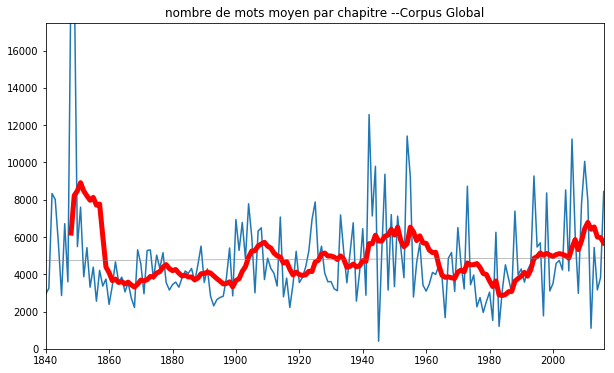

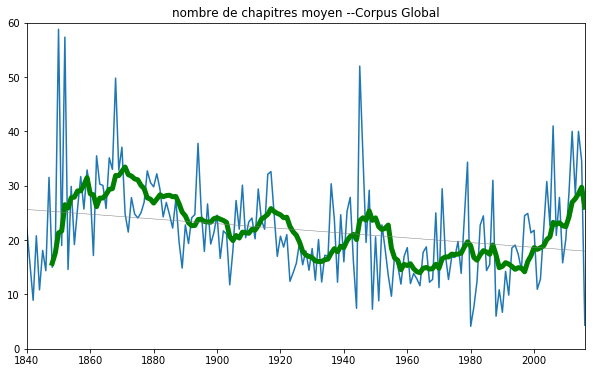

In [55]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[0,17500]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre --Corpus Global")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen --Corpus Global")

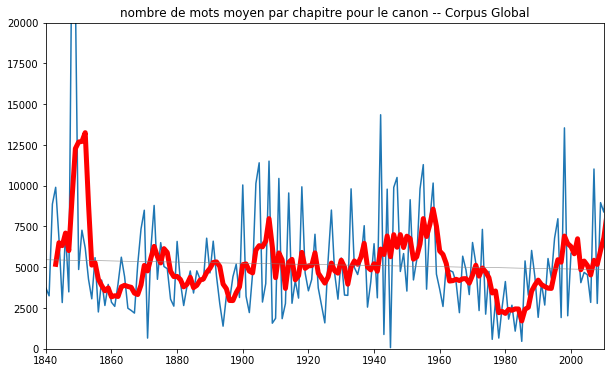

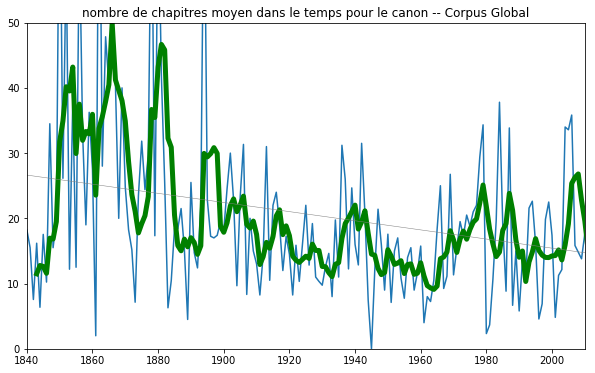

In [56]:
stats_canon=pickle.load(open( "stats_global_canon", "rb"))
limitsX=[1840,2010]
limitsWord=[0,20000]
limitsChap=[0,50]
sliding=5
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre pour le canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps pour le canon -- Corpus Global")

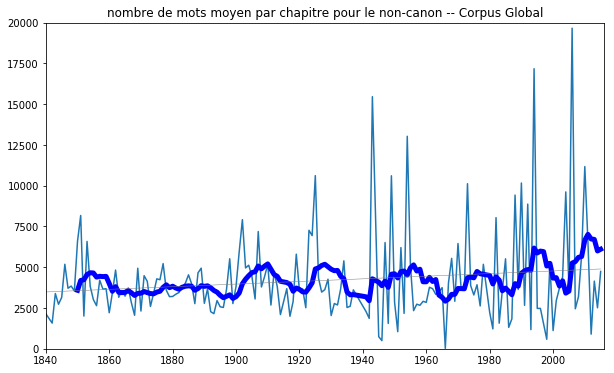

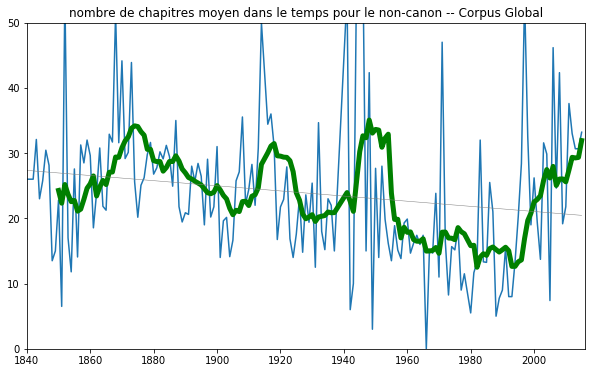

In [58]:
stats_canon=pickle.load(open( "stats_global_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,20000]
limitsChap=[0,50]
sliding=10
color=['b','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre pour le non-canon -- Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps pour le non-canon -- Corpus Global")

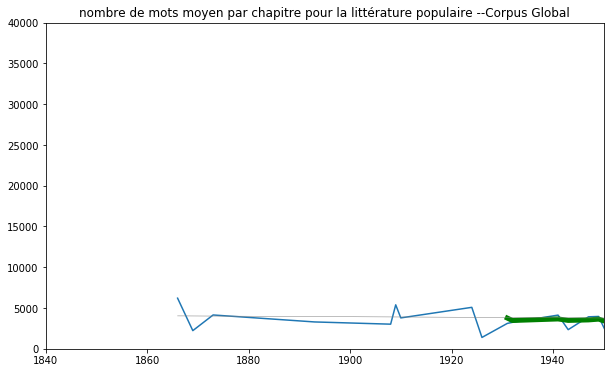

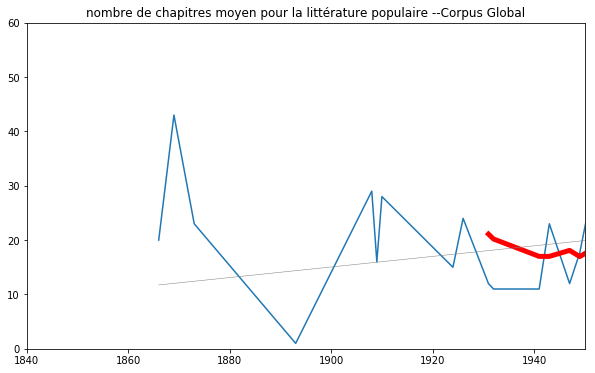

In [19]:
stats_canon=pickle.load(open( "stats_rest_policier", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Global")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Global")

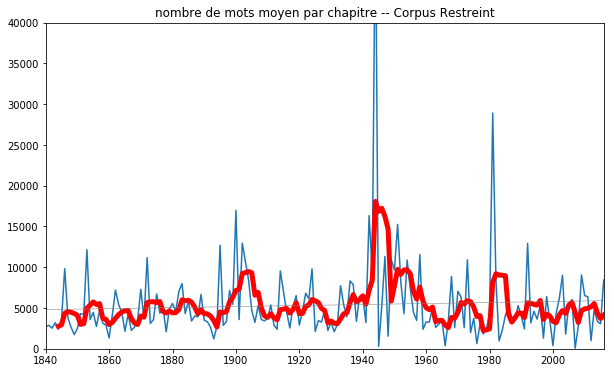

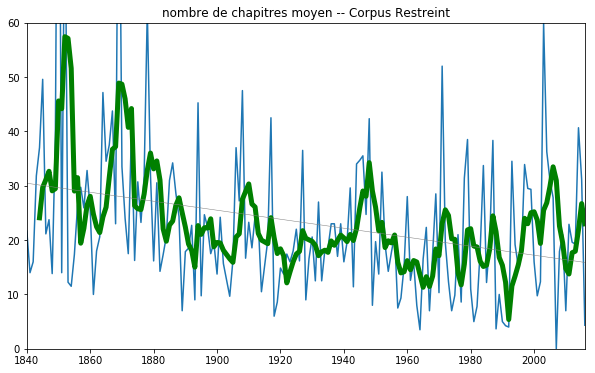

In [24]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=5
color=['r','g']
plot_stats(stats_global["word"][0],stats_global["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre -- Corpus Restreint")
plot_stats(stats_global["chapter"][0],stats_global["chapter"][1],limitsX,limitsChap,sliding,color[1],"nombre de chapitres moyen -- Corpus Restreint")

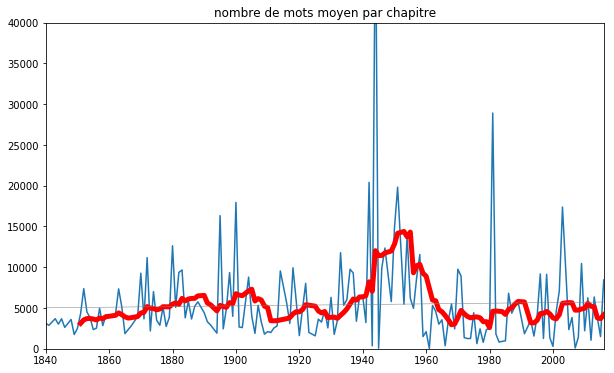

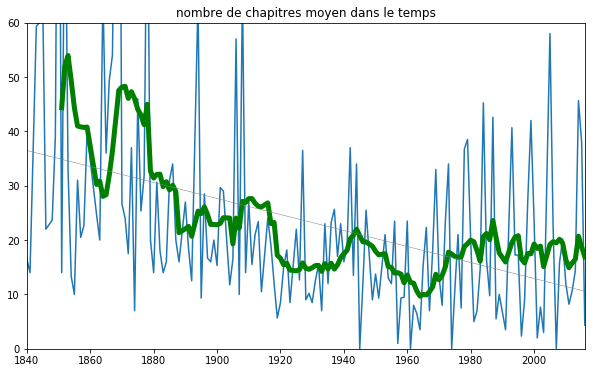

In [40]:
stats_canon=pickle.load(open( "stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

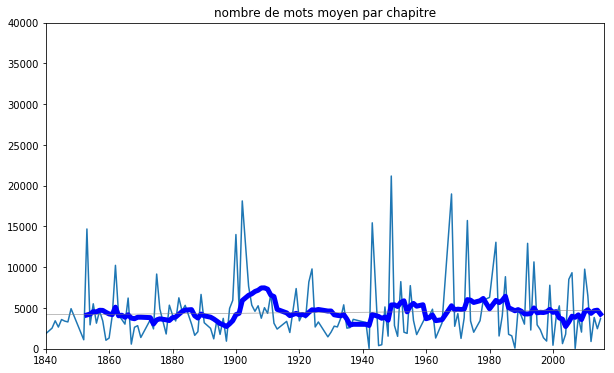

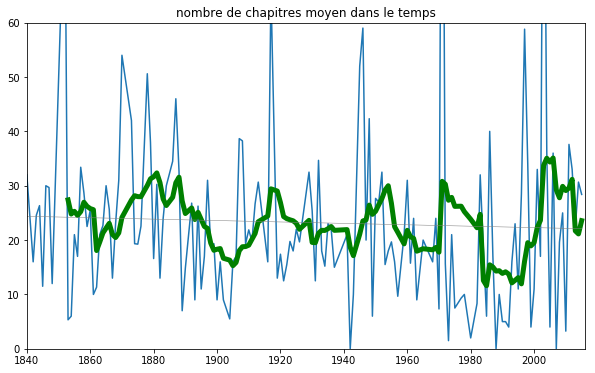

In [48]:
stats_canon=pickle.load(open( "stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['b','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[0],"nombre de mots moyen par chapitre")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[1],"nombre de chapitres moyen dans le temps")

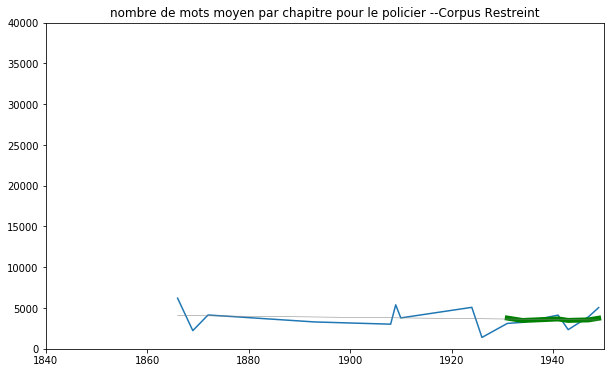

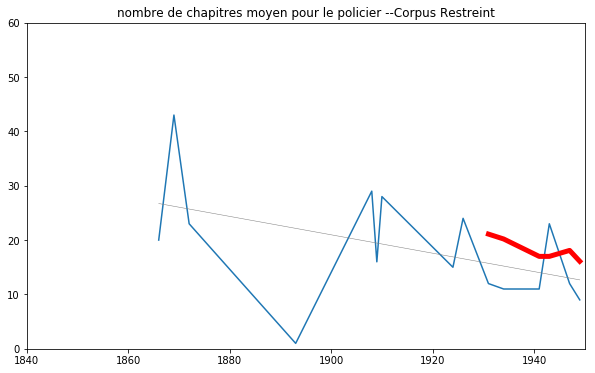

In [108]:
stats_canon=pickle.load(open( "stats_rest_policier", "rb"))
limitsX=[1840,1950]
limitsWord=[0,40000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour le policier --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour le policier --Corpus Restreint")

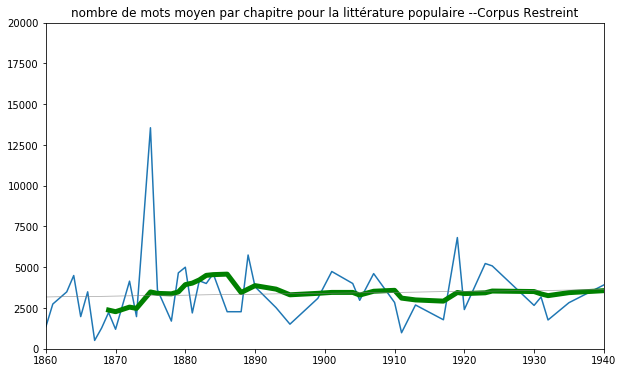

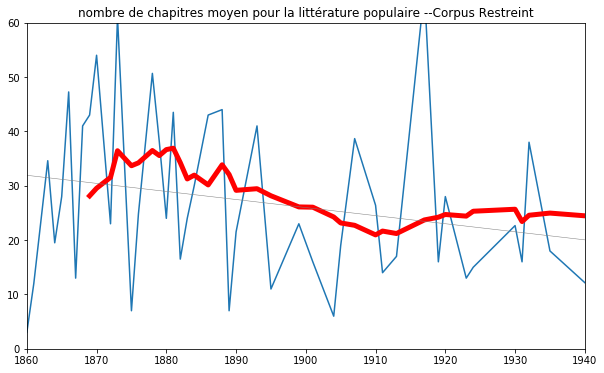

In [17]:
stats_canon=pickle.load(open( "stats_rest_populaire", "rb"))
limitsX=[1860,1940]
limitsWord=[0,20000]
limitsChap=[0,60]
sliding=10
color=['r','g']
plot_stats(stats_canon["word"][0],stats_canon["word"][1],limitsX,limitsWord,sliding,color[1],"nombre de mots moyen par chapitre pour la littérature populaire --Corpus Restreint")
plot_stats(stats_canon["chapter"][0],stats_canon["chapter"][1],limitsX, limitsChap,sliding,color[0],"nombre de chapitres moyen pour la littérature populaire --Corpus Restreint")

odict_keys(['_Dumas', '_Zola', '_Guy-de-Maupassant', '_Sand-G', '_Simenon', '_San-Antonio', '_Leblanc'])


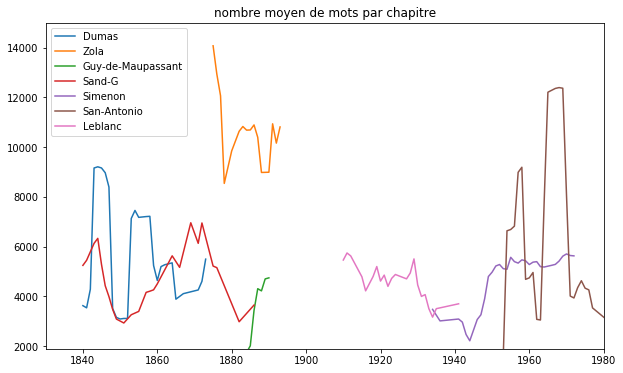

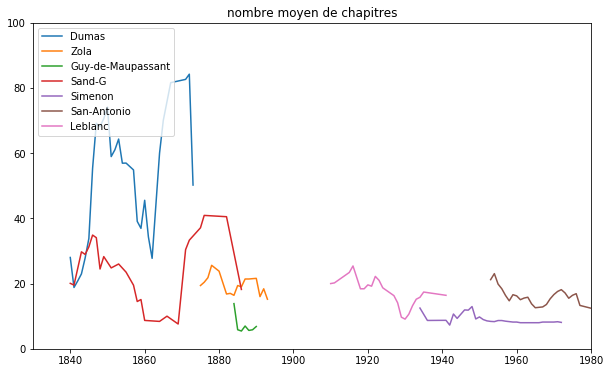

In [37]:
stats_authors=pickle.load(open("stats_authors","rb"))
print(stats_authors.keys())
multiple_plots(1830,1980, 15000,100,stats_authors)

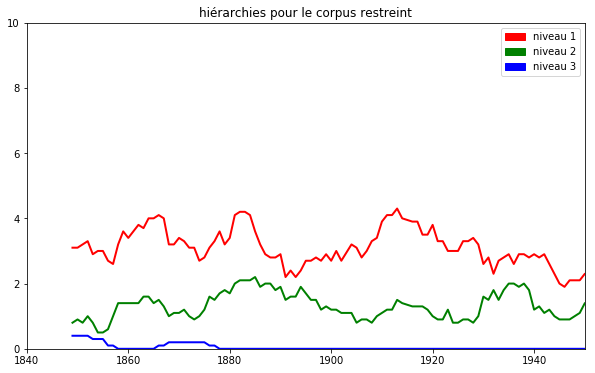

In [41]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,1950]
limitsWord=[0,10]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus restreint")

No handles with labels found to put in legend.


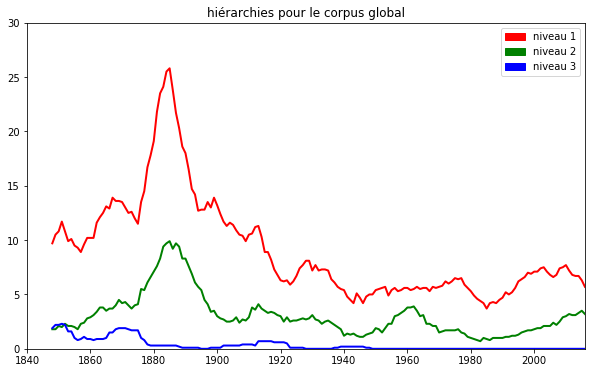

In [50]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[0,30]
color=['r','g','b']
sliding=10
hierarchy_plots(stats_global["divs"],limitsX,limitsWord, sliding, color, "hiérarchies pour le corpus global")

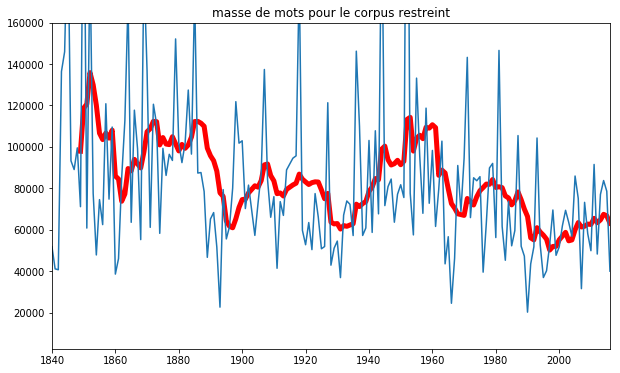

In [42]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,160000]
color='r'
sliding=10
simple_plot(stats_global["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint")

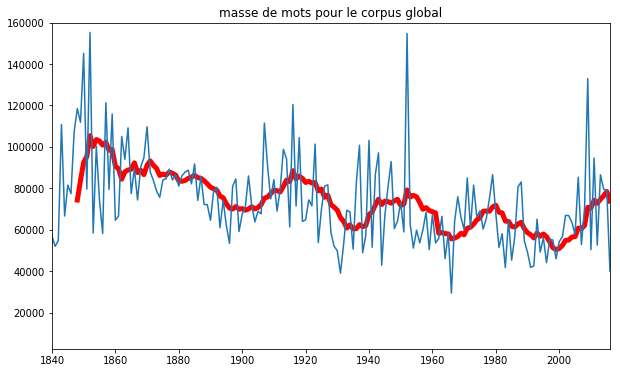

In [42]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,160000]
color='r'
sliding=10
simple_plot(stats_global["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus global")

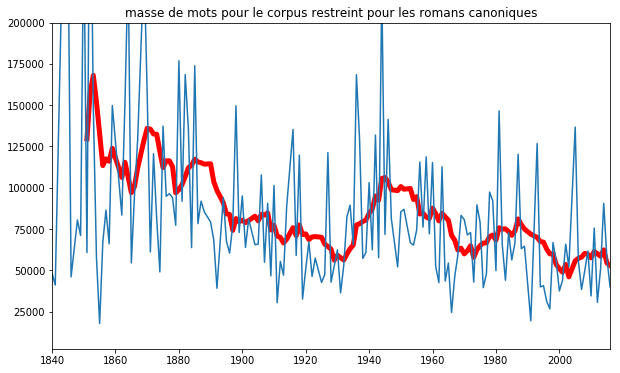

In [43]:
stats_canon=pickle.load(open("stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans canoniques")

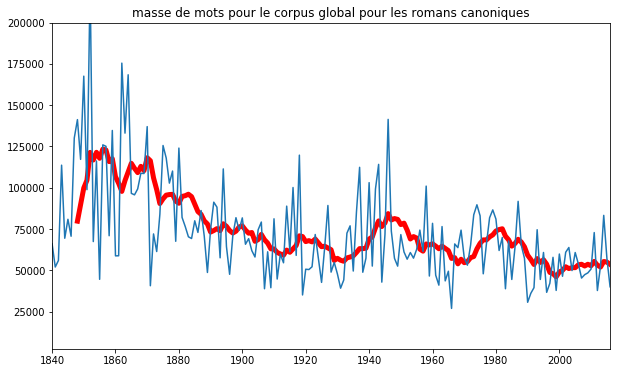

In [44]:
stats_canon=pickle.load(open("stats_global_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus global pour les romans canoniques")

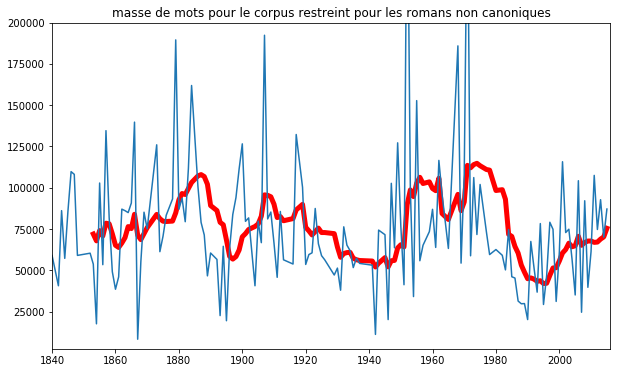

In [49]:
stats_non_canon=pickle.load(open("stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_non_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus restreint pour les romans non canoniques")

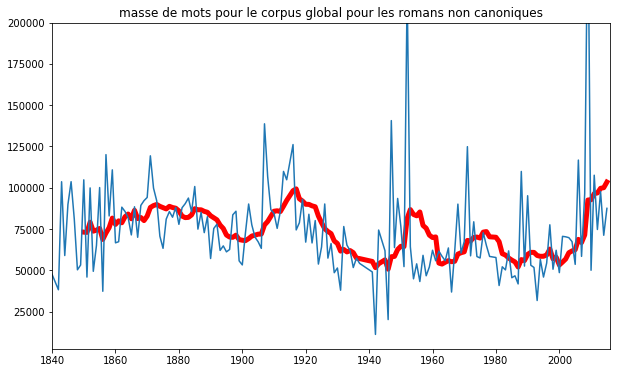

In [47]:
stats_non_canon=pickle.load(open("stats_global_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[2500,200000]
color='r'
sliding=10
simple_plot(stats_non_canon["length"][0],limitsX,limitsWord, sliding, color, "masse de mots pour le corpus global pour les romans non canoniques")

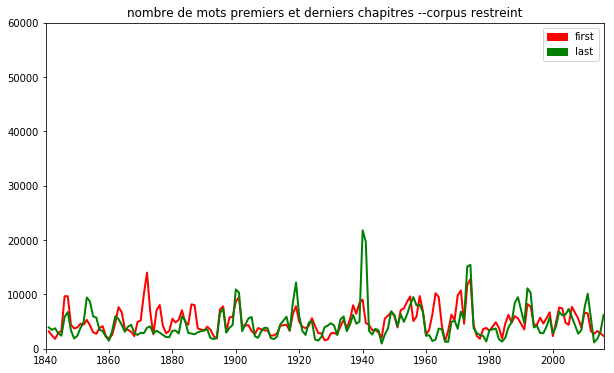

In [44]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint")

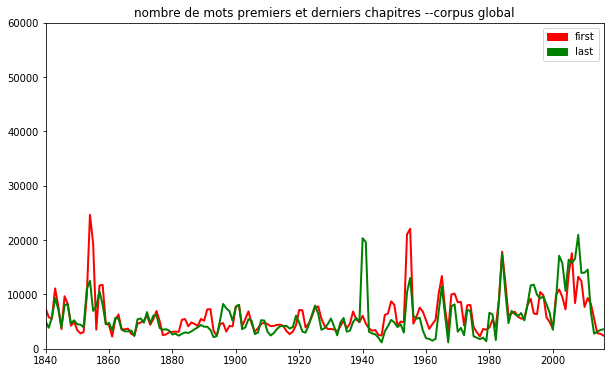

In [64]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus global")

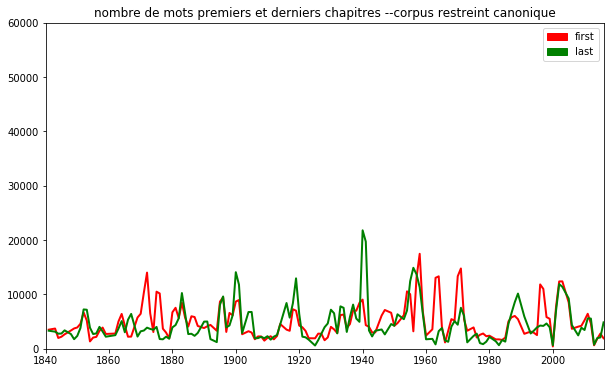

In [45]:
stats_global=pickle.load(open( "stats_rest_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint canonique")

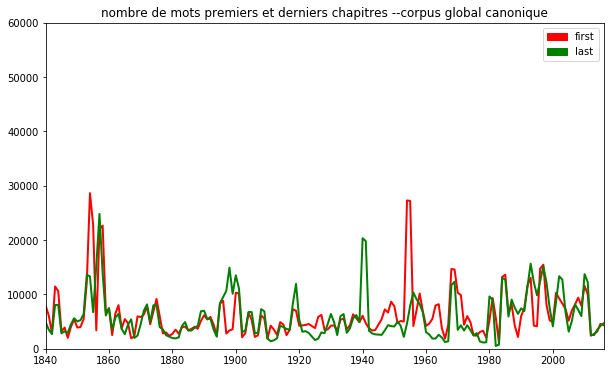

In [63]:
stats_global=pickle.load(open( "stats_global_canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=2
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus global canonique")

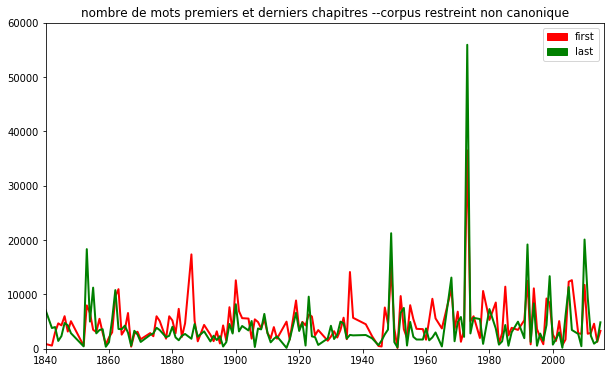

In [50]:
stats_global=pickle.load(open( "stats_rest_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=1
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus restreint non canonique")

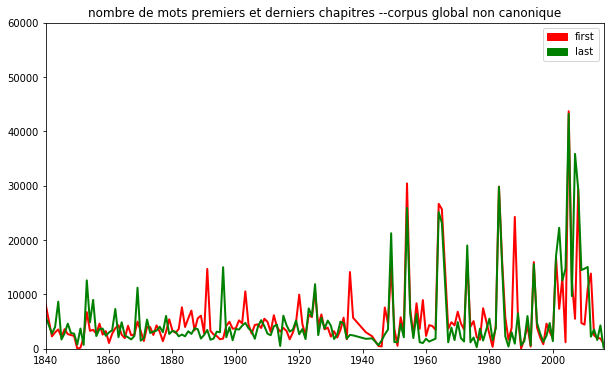

In [62]:
stats_global=pickle.load(open( "stats_global_non-canon", "rb"))
limitsX=[1840,2016]
limitsWord=[0,60000]
color=['r','g']
sliding=1
first_n_last_plots(stats_global["exts"],limitsX,limitsWord, sliding, color, "nombre de mots premiers et derniers chapitres --corpus global non canonique")

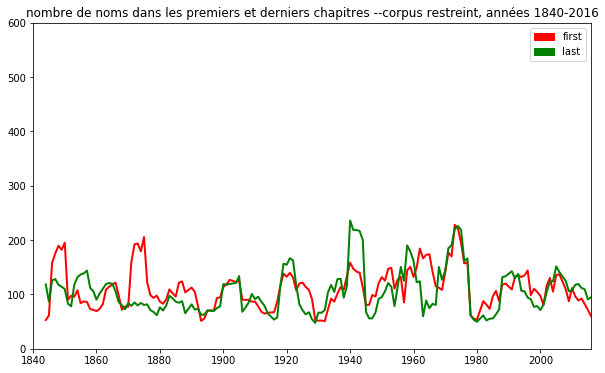

In [46]:
stats_global=pickle.load(open( "stats_rest", "rb"))
limitsX=[1840,2016]
limitsWord=[0,600]
color=['r','g']
sliding=5
first_n_last_plots(stats_global["ents"],limitsX,limitsWord, sliding, color, "nombre de noms dans les premiers et derniers chapitres --corpus restreint, années 1840-2016")

No handles with labels found to put in legend.


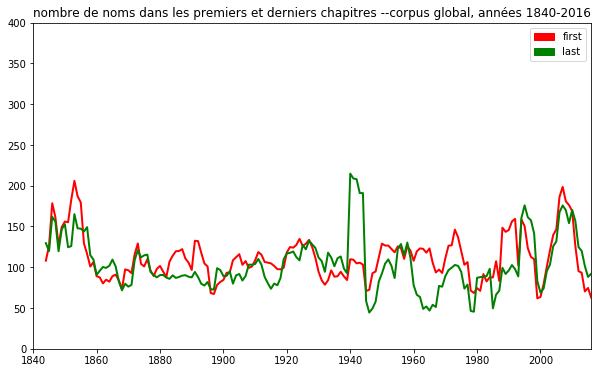

In [52]:
stats_global=pickle.load(open( "stats_global", "rb"))
limitsX=[1840,2016]
limitsWord=[0,400]
color=['r','g']
sliding=5
first_n_last_plots(stats_global["ents"],limitsX,limitsWord, sliding, color, "nombre de noms dans les premiers et derniers chapitres --corpus global, années 1840-2016")